# Covid Use Case

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from pathlib import Path

from nvita.models.data import SplittedTSData
from nvita.models.lstm import LSTM
import nvita.models.train as mt
from nvita.models.utils import save_model, load_model

In [2]:
PATH_ROOT = Path(os.getcwd()).parent.absolute()
PATH_RAW = os.path.join(PATH_ROOT, "data", "raw_data")
PATH_CLEAN = os.path.join(PATH_ROOT, "data", "clean_data")

seed = 2210
TEST_SIZE = 70
VALID_PER = 0.2

In [3]:
covid_df_all = pd.read_csv(os.path.join(PATH_RAW, "owid-covid-data.csv"), sep = ",")

In [4]:
covid_df = covid_df_all[covid_df_all["location"] == "United States"]

In [5]:
covid_df.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

In [6]:
# Select features
col_list = ["new_cases", "new_deaths", "icu_patients", "hosp_patients", "new_tests", "new_vaccinations", "stringency_index", "population", "gdp_per_capita"]

covid_df = covid_df[col_list]


In [7]:
covid_df = covid_df.iloc[175:879, :]
covid_df["new_vaccinations"] = covid_df["new_vaccinations"].fillna(0)

In [8]:
# Make sure there is no NaN in clean df
covid_df.isnull().values.sum()

0

In [10]:
covid_df.to_csv(os.path.join(PATH_CLEAN, "CovidUSA.csv"), index = False)

In [11]:
covid_df.shape

(704, 9)

In [15]:
path_df = os.path.join(PATH_ROOT, "data", "clean_data", "CovidUSA" +".csv")

s_data = SplittedTSData(path_df, "CovidUSA", "new_cases", 7, int(seed))
s_data.train_valid_test_split(TEST_SIZE, VALID_PER)
s_data.save_splitted_data(PATH_ROOT)

In [44]:
s_data = SplittedTSData()
s_data = s_data.load_splitted_data(PATH_ROOT, "CovidUSA", seed)
epoch, lr, input_dim, hidden_dim, num_layers, output_dim = [500, 0.01, s_data.X_train.shape[2], 64, 1, 1]
model = LSTM(input_dim, hidden_dim, num_layers, output_dim)
mt.train(model, lr, epoch, s_data.X_train, s_data.y_train)

array([0.01713058, 0.01852314, 0.00848766, 0.00661869, 0.00839278,
       0.00808902, 0.00616847, 0.00486618, 0.00517022, 0.00592815,
       0.00504732, 0.00418017, 0.00372499, 0.00387884, 0.00409593,
       0.00373806, 0.00311762, 0.00273669, 0.00290046, 0.00332208,
       0.00274924, 0.00246707, 0.00263972, 0.00288159, 0.00270231,
       0.00243889, 0.00238613, 0.00250312, 0.00258602, 0.00241745,
       0.0022293 , 0.00232382, 0.00235121, 0.00227591, 0.00215132,
       0.00214916, 0.00221704, 0.00219751, 0.00212769, 0.00210279,
       0.00216007, 0.00215875, 0.00209343, 0.00206086, 0.00206357,
       0.00204602, 0.00201549, 0.0019951 , 0.00200037, 0.0019676 ,
       0.00195229, 0.00194268, 0.00193434, 0.00191877, 0.00190562,
       0.00191479, 0.00187671, 0.00186308, 0.00186239, 0.00186441,
       0.00182452, 0.00181652, 0.00179837, 0.00178112, 0.00176589,
       0.00177242, 0.00174463, 0.00172517, 0.00173706, 0.00173351,
       0.00168151, 0.0017008 , 0.00163457, 0.00164473, 0.00159

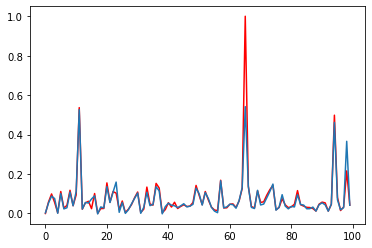

In [50]:
# Visulaize the model prediction
plt.plot(s_data.y_test, color = "Red") # Ground truth is red
plt.plot(mt.predict(model, s_data.X_test).detach().numpy())

In [34]:
score = np.mean(mt.evaluate(model, s_data.X_test, s_data.y_test)**2)
save_model(model, PATH_ROOT, s_data.df_name, s_data.seed)